<h2 style="text-align:center; color:#546545;text-shadow: 2px 2px 4px #000000;"> A comparison of different classifiers’ accuracy & performance for high-dimensional data</h2>

<h2 style="text-align:center; color:#546545;text-shadow: 2px 2px 4px #000000;">Problem formulation</h2>

The **EEG Brainwave Dataset** contains electronic brainwave signals from an EEG headset and is in temporal format.

The challenge is: **Can we predict emotional sentiment from brainwave readings?**

<h2 style="text-align:center; color:#546545;text-shadow: 2px 2px 4px #000000;">Import Packages</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

import os
os.listdir('../input')

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout, Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


In [2]:
brainwave_df = pd.read_csv('../input/emotions.csv')

<h2 style="text-align:center; color:#546545;text-shadow: 2px 2px 4px #000000;">Peek of Data</h2>

In [3]:
brainwave_df.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,mean_d_0_a2,mean_d_1_a2,mean_d_2_a2,mean_d_3_a2,mean_d_4_a2,mean_d_5_a,mean_d_6_a,mean_d_7_a,mean_d_8_a,mean_d_9_a,mean_d_10_a,mean_d_11_a,mean_d_12_a,mean_d_13_a,mean_d_14_a,mean_d_15_a,mean_d_16_a,mean_d_17_a,mean_d_18_a,mean_d_19_a,mean_d_20_a,mean_d_21_a,mean_d_22_a,mean_d_23_a,mean_d_24_a,mean_d_25_a,mean_d_26_a,mean_d_27_a,mean_d_28_a,mean_d_29_a,...,fft_711_b,fft_712_b,fft_713_b,fft_714_b,fft_715_b,fft_716_b,fft_717_b,fft_718_b,fft_719_b,fft_720_b,fft_721_b,fft_722_b,fft_723_b,fft_724_b,fft_725_b,fft_726_b,fft_727_b,fft_728_b,fft_729_b,fft_730_b,fft_731_b,fft_732_b,fft_733_b,fft_734_b,fft_735_b,fft_736_b,fft_737_b,fft_738_b,fft_739_b,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,2.15,29.5,-353.0,14.40,21.5,5.98,30.7,-343.0,14.7,27.9,3.17,32.2,-368.0,15.9,36.4,7.08,28.8,-359.0,17.3,19.6,-3.8300,-1.230,-10.80000,-0.363,-6.41,-1.03,-2.780,14.60,-1.540,-14.900000,...,30.90,-24.4,-24.4,30.90,-442.0,388.0,-197.0,-197.0,388.0,-564.0,500.00,-245.00,-245.00,500.00,-88.8,214.0,-88.8,-88.8,214.0,-606.0,509.000,-261.0,-261.0,509.000,-399.0,374.0,-185.00,-185.00,374.0,74.3,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,25.60,32.8,29.6,21.50,17.4,25.50,31.7,31.5,26.2,32.9,31.80,33.1,33.2,28.5,26.8,32.40,34.7,33.8,27.0,14.2,0.0342,1.100,-1.87000,-4.690,-15.40,-6.22,-0.328,-3.53,-6.980,-9.370000,...,-5.99,-19.1,-19.1,-5.99,163.0,-11.0,-10.7,-10.7,-11.0,117.0,-3.93,17.90,17.90,-3.93,112.0,-13.9,25.5,25.5,-13.9,225.0,-0.968,-27.7,-27.7,-0.968,97.4,-19.0,40.70,40.70,-19.0,130.0,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,7.75,30.1,-441.0,9.89,25.3,-68.90,25.3,-481.0,-65.4,20.0,79.80,31.0,-408.0,91.9,29.5,18.80,31.1,-335.0,32.2,19.9,76.6000,4.850,39.90000,75.300,5.27,-72.00,-0.843,-33.00,-82.000,-4.200000,...,585.00,-285.0,-285.0,585.00,-94.3,183.0,-110.0,-110.0,183.0,-133.0,200.00,-72.00,-72.00,200.00,-356.0,295.0,-158.0,-158.0,295.0,-251.0,255.000,-95.7,-95.7,255.000,-177.0,159.0,-48.80,-48.80,159.0,-534.0,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,17.30,32.0,-148.0,20.40,22.8,13.20,31.5,-147.0,16.9,27.7,15.70,30.7,-142.0,20.7,22.8,13.60,32.2,-135.0,21.2,23.8,4.1500,0.556,-0.35400,3.460,-4.96,1.63,1.330,-5.83,-0.298,0.000777,...,249.00,-146.0,-146.0,249.00,359.0,-146.0,13.7,13.7,-146.0,119.0,-7.64,-7.17,-7.17,-7.64,-296.0,316.0,-218.0,-218.0,316.0,322.0,-113.000,38.4,38.4,-113.000,245.0,-61.9,-5.08,-5.08,-61.9,-183.0,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,26.10,34.3,43.7,23.70,20.6,-3.87,34.1,43.7,-10.0,22.9,59.40,26.7,60.3,64.7,26.9,32.30,30.1,33.6,31.6,27.7,30.0000,0.276,-0.00677,33.700,-2.36,-33.30,7.640,-16.60,-41.100,-6.290000,...,18.30,-11.9,-11.9,18.30,159.0,-18.2,-25.6,-25.6,-18.2,194.0,32.70,-54.50,-54.50,32.70,154.0,26.4,-56.4,-56.4,26.4,252.0,9.940,-37.4,-37.4,9.940,172.0,15.9,-7.25,-7.25,15.9,114.0,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


<h2 style="text-align:center; color:#546545;text-shadow: 2px 2px 4px #000000;">Dimensions of Data

In [4]:
brainwave_df.shape

(2132, 2549)

<h2 style="text-align:center; color:#546545;text-shadow: 2px 2px 4px #000000;">Descriptive Statistics</h2>

In [5]:
brainwave_df.describe()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,mean_d_0_a2,mean_d_1_a2,mean_d_2_a2,mean_d_3_a2,mean_d_4_a2,mean_d_5_a,mean_d_6_a,mean_d_7_a,mean_d_8_a,mean_d_9_a,mean_d_10_a,mean_d_11_a,mean_d_12_a,mean_d_13_a,mean_d_14_a,mean_d_15_a,mean_d_16_a,mean_d_17_a,mean_d_18_a,mean_d_19_a,mean_d_20_a,mean_d_21_a,mean_d_22_a,mean_d_23_a,mean_d_24_a,mean_d_25_a,mean_d_26_a,mean_d_27_a,mean_d_28_a,mean_d_29_a,...,fft_710_b,fft_711_b,fft_712_b,fft_713_b,fft_714_b,fft_715_b,fft_716_b,fft_717_b,fft_718_b,fft_719_b,fft_720_b,fft_721_b,fft_722_b,fft_723_b,fft_724_b,fft_725_b,fft_726_b,fft_727_b,fft_728_b,fft_729_b,fft_730_b,fft_731_b,fft_732_b,fft_733_b,fft_734_b,fft_735_b,fft_736_b,fft_737_b,fft_738_b,fft_739_b,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b
count,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.00000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,...,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000
mean,15.256914,27.012462,-104.975629,13.605898,24.150483,0.025378,0.052282,0.301655,0.036793,0.083567,14.434887,26.908907,-105.588740,12.887584,23.926767,16.033058,27.060702,-104.679376,14.267053,24.283368,14.467447,26.959896,-105.381444,12.933635,24.003451,16.049431,27.114985,-104.290668,14.294105,24.373668,-1.599357,-0.152583,-0.91247,-1.378962,-0.356195,-0.032664,-0.051330,-0.200058,-0.047101,-0.078052,...,-17.779184,100.599180,-50.470534,-50.470534,100.599180,-14.045472,98.857898,-49.384255,-49.384255,98.857898,-40.212686,115.890981,-60.818355,-60.818355,115.890981,-20.803073,104.579728,-52.482214,-52.482214,104.579728,-10.266162,98.024481,-49.860683,-49.860683,98.024481,-39.805323,115.850926,-61.034371,-61.034371,115.850926,-22.938971,104.946111,-51.973647,-51.973647,104.946111,-6.934144,95.104886,-49.061255,-49.061255,95.104886
std,15.284621,9.265141,206.271960,16.874676,14.187340,17.981796,8.509174,68.098894,17.010031,18.935378,19.515474,11.879437,211.103804,22.367222,22.135017,24.429661,13.780414,211.082473,23.307269,16.597016,19.511804,11.860676,211.000691,22.357290,21.953792,24.443949,13.737191,210.671349,23.324362,16.212550,26.531211,15.661044,56.10358,25.660613,18.423602,23.823391,11.527922,81.363041,22.721501,29.003355,...,297.738725,208.675512,111.953662,111.953662,208.675512,286.038456,205.488648,107.187240,107.187240,205.488648,288.197813,202.162746,108.728352,108.728352,202.162746,300.098178,212.554149,113.610157,113.610157,212.554149,285.143736,205.199001,105.688402,105.688402,205.199001,287.708665,202.269233,109.084649,109.084649,202.269233,298.034311,212.532721,112.160233,112.160233,212.532721,281.040552,203.194976,106.486317,106.486317,203.194976
min,-61.300000,-114.000000,-970.000000,-137.000000,-217.000000,-218.000000,-255.000000,-1360.000000,-203.000000,-553.000000,-190.000000,-310.000000,-970.000000,-253.000000,-750.000000,-125.000000,-368.000000,-970.000000,-131.000000,-140.000000,-191.000000,-312.000000,-970.000000,-254.000000,-754.000000,-125.000000,-368.000000,-973.000000,-131.000000,-137.000000,-465.000000,-646.000000,-1130.00000,-540.000000,-614.000000,-319.000000,-428.000000,-1140.000000,-196.000000,

<h2 style="text-align:center; color:#546545;text-shadow: 2px 2px 4px #000000;">Class Distribution</h2>

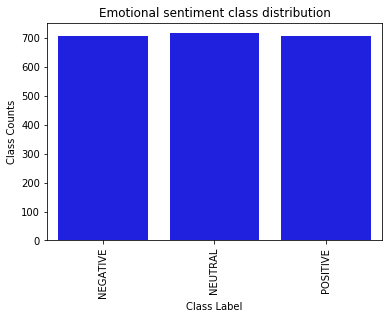

In [6]:
plt.figure()
sns.countplot(x=brainwave_df.label, color='blue')
plt.title('Emotional sentiment class distribution')
plt.ylabel('Class Counts')
plt.xlabel('Class Label')
plt.xticks(rotation='vertical');

<h2 style="text-align:center; color:#546545;text-shadow: 2px 2px 4px #000000;">Correlation Between Attributes</h2>
Correlation refers to the relationship between two variables and how they may or may not change together.

The most common method for calculating correlation is [Pearson’s Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient), that assumes a normal distribution of the attributes involved. A correlation of -1 or 1 shows a full negative or positive correlation respectively. Whereas a value of 0 shows no correlation at all.

In [7]:
label_df = brainwave_df['label']
brainwave_df.drop('label', axis = 1, inplace=True)

In [8]:
correlations = brainwave_df.corr(method='pearson')
correlations

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,mean_d_0_a2,mean_d_1_a2,mean_d_2_a2,mean_d_3_a2,mean_d_4_a2,mean_d_5_a,mean_d_6_a,mean_d_7_a,mean_d_8_a,mean_d_9_a,mean_d_10_a,mean_d_11_a,mean_d_12_a,mean_d_13_a,mean_d_14_a,mean_d_15_a,mean_d_16_a,mean_d_17_a,mean_d_18_a,mean_d_19_a,mean_d_20_a,mean_d_21_a,mean_d_22_a,mean_d_23_a,mean_d_24_a,mean_d_25_a,mean_d_26_a,mean_d_27_a,mean_d_28_a,mean_d_29_a,...,fft_710_b,fft_711_b,fft_712_b,fft_713_b,fft_714_b,fft_715_b,fft_716_b,fft_717_b,fft_718_b,fft_719_b,fft_720_b,fft_721_b,fft_722_b,fft_723_b,fft_724_b,fft_725_b,fft_726_b,fft_727_b,fft_728_b,fft_729_b,fft_730_b,fft_731_b,fft_732_b,fft_733_b,fft_734_b,fft_735_b,fft_736_b,fft_737_b,fft_738_b,fft_739_b,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b
# mean_0_a,1.000000,0.176578,0.429810,0.582697,0.178432,-0.000665,0.105961,-0.061046,0.135370,0.008472,0.631592,0.133139,0.413581,0.297065,0.105071,0.743918,0.057339,0.445693,0.457342,0.155169,0.600544,0.016193,0.434545,0.336183,0.137812,0.766717,0.286009,0.387308,0.615781,0.136301,-0.220809,0.049749,-0.120448,-0.156487,-0.013484,0.025160,0.120695,-0.053593,-0.038564,-0.023876,...,0.294465,-0.237807,0.195015,0.195015,-0.237807,0.278300,-0.219158,0.186809,0.186809,-0.219158,0.304622,-0.215613,0.243759,0.243759,-0.215613,0.292960,-0.223324,0.195317,0.195317,-0.223324,0.275208,-0.232244,0.207687,0.207687,-0.232244,0.307273,-0.213692,0.250135,0.250135,-0.213692,0.301672,-0.245671,0.204764,0.204764,-0.245671,0.268983,-0.220566,0.196653,0.196653,-0.220566
mean_1_a,0.176578,1.000000,-0.007202,0.571530,0.385041,-0.088608,-0.007586,-0.050463,-0.119391,-0.017197,0.238502,0.694615,0.023673,0.499635,0.242325,0.096968,0.749630,-0.020829,0.435720,0.354491,0.242985,0.907825,-0.033771,0.477140,0.228885,-0.035553,0.563863,0.002966,0.284654,0.343794,0.086335,-0.132334,0.167025,0.039613,-0.028082,-0.003574,-0.218491,0.148634,0.022418,0.011878,...,0.153682,-0.062301,0.042891,0.042891,-0.062301,0.164843,-0.100678,0.104904,0.104904,-0.100678,0.135831,-0.023771,0.073219,0.073219,-0.023771,0.133219,-0.058794,0.022226,0.022226,-0.058794,0.166098,-0.095997,0.088590,0.088590,-0.095997,0.121829,-0.017769,0.039049,0.039049,-0.017769,0.130717,-0.047208,0.002549,0.002549,-0.047208,0.153244,-0.096173,0.069532,0.069532,-0.096173
mean_2_a,0.429810,-0.007202,1.000000,0.081567,-0.095696,0.015122,0.014605,-0.004320,0.055625,-0.003564,0.307148,0.011243,0.969231,0.026965,-0.063746,0.280730,-0.028057,0.986330,0.051253,-0.074694,0.307409,-0.031549,0.985017,0.053555,-0.068278,0.302433,0.025905,0.970505,0.106492,-0.079325,-0.032677,0.033099,-0.063791,-0.023063,-0.009356,-0.000190,0.044186,-0.039671,-0.026218,0.003007,...,0.680455,-0.727452,0.600970,0.600970,-0.727452,0.680175,-0.740372,0.576588,0.576588,-0.740372,0.659387,-0.710382,0.581474,0.581474,-0.710382,0.686590,-0.729253,0.608599,0.608599,-0.729253,0.679187,-0.740853,0.585721,0.585721,-0.740853,0.660247,-0.702943,0.570398,0.570398,-0.702943,0.699461,-0.742275,0.622567,0.622567,-0.742275,0.674195,-0.728296,0.565044,0.565044,-0.728296
mean_3_a,0.582697,0.571530,0.081567,1.000000,0.220842,-0.117748,0.124462,-0.175592,-0.001782,0.017110,0.491643,0.355417,0.130558,0.729776,0.131394,0.422736,0.384841,0.086126,0.747839,0.182771,0.433127,0.474102,0.067855,0.756893,0.161667,0.296715,0.438547,0.035471,0.719618,0.188067,-0.027659,-0.069191,0.166878,-0.043435,-0.006755,0.047880,-0.121715,0.162453,-0.026594,-0.021834,...,0.139081,-0.066359,0.075843,0.075843,-0.066359,0.117987,-0.059526,0.073933,0.073933,-0.059526,0.107666,-0.014347,0.074685,0.074685,-0.014347,0.135228,-0.067007,0.058590,0.058590,-0.067007,0.116846,-0.064706,0.068581,0.068581,-0.064706,0.098135,-0.012625,0.053341,0.053341,-0.012625,0.133720,-0.067460,0.048202,0.048202,-0.067460,0.103294,-0.061376,0.051216,0.051216,-0.061376
mean_4_a,0.178432,0.385041,-0.095696,0.220842,1.000000,-0.017196,-0.007570,0.025546,-0.0334

<h2 style="text-align:center; color:#546545;text-shadow: 2px 2px 4px #000000;">Skew of Univariate Distributions</h2>

In [9]:
skew = brainwave_df.skew()
skew

# mean_0_a      3.839961
mean_1_a       -5.400903
mean_2_a       -1.769376
mean_3_a        0.293842
mean_4_a       -3.911369
mean_d_0_a      5.037609
mean_d_1_a      0.259055
mean_d_2_a     -2.678249
mean_d_3_a      4.729592
mean_d_4_a     -5.799641
mean_d_0_a2    -1.280704
mean_d_1_a2   -12.338497
mean_d_2_a2    -1.557033
mean_d_3_a2    -1.505519
mean_d_4_a2   -19.863973
mean_d_5_a      9.340996
mean_d_6_a     -6.490151
mean_d_7_a     -1.619659
mean_d_8_a      3.061302
mean_d_9_a      8.191188
mean_d_10_a    -1.296867
mean_d_11_a   -12.576537
mean_d_12_a    -1.558395
mean_d_13_a    -1.506060
mean_d_14_a   -20.465480
mean_d_15_a     9.316563
mean_d_16_a    -6.483794
mean_d_17_a    -1.626358
mean_d_18_a     3.039943
mean_d_19_a     9.258123
                 ...    
fft_720_b      -1.165149
fft_721_b       1.289832
fft_722_b       0.751271
fft_723_b       0.751271
fft_724_b       1.289832
fft_725_b      -1.271173
fft_726_b       1.322905
fft_727_b       0.663377
fft_728_b       0.663377


<h2 style="text-align:center; color:#546545;text-shadow: 2px 2px 4px #000000;">RandomForest Classifier</h2>

`RandomForest` is a tree & bagging approach-based ensemble classifier. It will automatically reduce the number of features by its probabilistic entropy calculation approach.

In [10]:
%%time

pl_random_forest = Pipeline(steps=[('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest, brainwave_df, label_df, cv=10,scoring='accuracy')
print('Accuracy for RandomForest : ', scores.mean())

Accuracy for RandomForest :  0.9770409392915346
CPU times: user 4.83 s, sys: 227 ms, total: 5.05 s
Wall time: 5.05 s


<h2 style="text-align:center; color:#546545;text-shadow: 2px 2px 4px #000000;">Logistic Regression Classifier</h2>

`Logistic Regression` is a linear classifier and works in same way as linear regression.

In [11]:
%%time

pl_log_reg = Pipeline(steps=[('scaler',StandardScaler()),
                             ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=200))])
scores = cross_val_score(pl_log_reg, brainwave_df, label_df, cv=10,scoring='accuracy')
print('Accuracy for Logistic Regression: ', scores.mean())

Accuracy for Logistic Regression:  0.9319778573108491
CPU times: user 3min 52s, sys: 3.64 s, total: 3min 55s
Wall time: 3min 52s


<h2 style="text-align:center; color:#546545;text-shadow: 2px 2px 4px #000000;">Principal Component Analysis (PCA)</h2>

PCA can transform original low level variables to a higher dimensional space and thus reduce the number of required variables. All co-linear variables get clubbed together. 

In [12]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(brainwave_df)
pca = PCA(n_components = 30)
pca_vectors = pca.fit_transform(scaled_df)
for index, var in enumerate(pca.explained_variance_ratio_):
    print("Explained Variance ratio by Principal Component ", (index+1), " : ", var)


Explained Variance ratio by Principal Component  1  :  0.36772564117538736
Explained Variance ratio by Principal Component  2  :  0.09553894257232595
Explained Variance ratio by Principal Component  3  :  0.08436069000482474
Explained Variance ratio by Principal Component  4  :  0.0608566518197018
Explained Variance ratio by Principal Component  5  :  0.047453732926251366
Explained Variance ratio by Principal Component  6  :  0.03082305251847145
Explained Variance ratio by Principal Component  7  :  0.024721620860921233
Explained Variance ratio by Principal Component  8  :  0.013753055070762224
Explained Variance ratio by Principal Component  9  :  0.012408702721219562
Explained Variance ratio by Principal Component  10  :  0.01210365357216167
Explained Variance ratio by Principal Component  11  :  0.009557100578249586
Explained Variance ratio by Principal Component  12  :  0.009164311022304056
Explained Variance ratio by Principal Component  13  :  0.008740057336863897
Explained Varia

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 <a list of 9 Text xticklabel objects>)

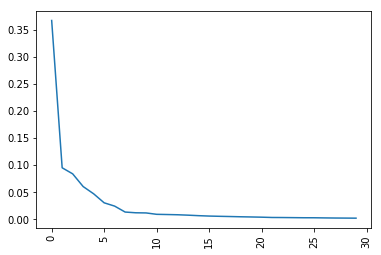

In [13]:
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.xticks(rotation='vertical')

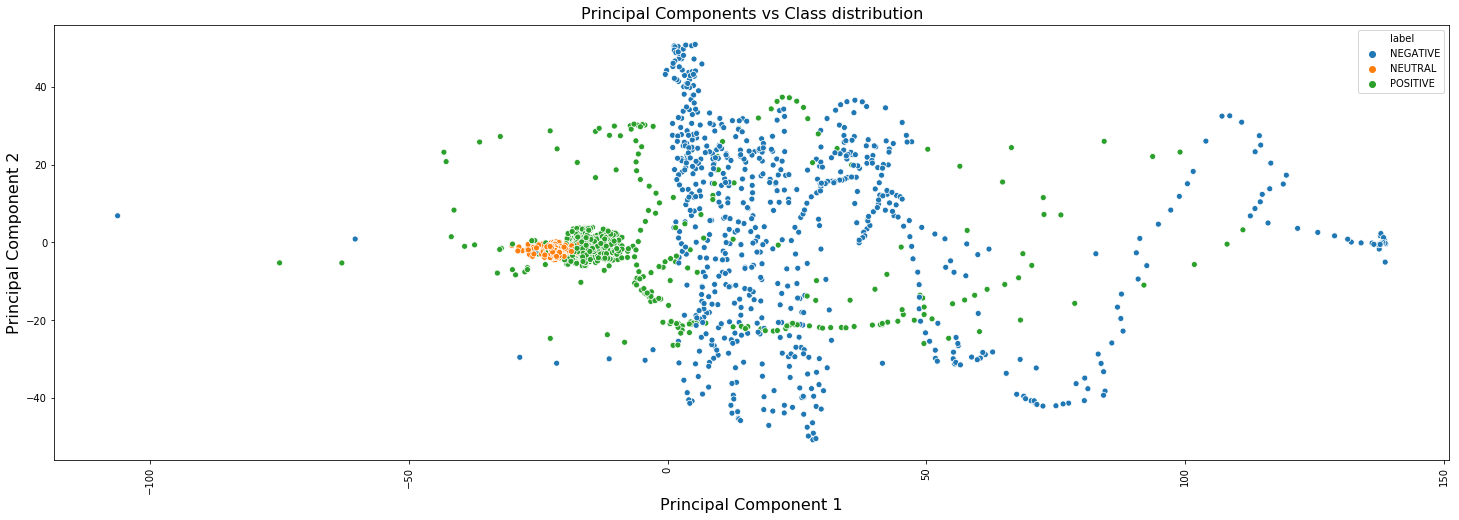

In [14]:
plt.figure(figsize=(25,8))
sns.scatterplot(x=pca_vectors[:, 0], y=pca_vectors[:, 1], hue=label_df)
plt.title('Principal Components vs Class distribution', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=16)
plt.xticks(rotation='vertical');

<h2 style="text-align:center; color:#546545;text-shadow: 2px 2px 4px #000000;">Logistic Regression classifier with these two PCs</h2>

In [15]:
%%time
pl_log_reg_pca = Pipeline(steps=[('scaler',StandardScaler()),
                             ('pca', PCA(n_components = 2)),
                             ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=200))])
scores = cross_val_score(pl_log_reg_pca, brainwave_df, label_df, cv=10,scoring='accuracy')
print('Accuracy for Logistic Regression with 2 Principal Components: ', scores.mean())

Accuracy for Logistic Regression with 2 Principal Components:  0.7752487834538495
CPU times: user 11.5 s, sys: 6.87 s, total: 18.4 s
Wall time: 7.35 s


<h2 style="text-align:center; color:#546545;text-shadow: 2px 2px 4px #000000;">Take all 10 PCs</h2>

In [16]:
%%time

pl_log_reg_pca_10 = Pipeline(steps=[('scaler',StandardScaler()),
                             ('pca', PCA(n_components = 10)),
                             ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=200))])
scores = cross_val_score(pl_log_reg_pca_10, brainwave_df, label_df, cv=10,scoring='accuracy')
print('Accuracy for Logistic Regression with 10 Principal Components: ', scores.mean())

Accuracy for Logistic Regression with 10 Principal Components:  0.865842673825059
CPU times: user 13 s, sys: 6.83 s, total: 19.9 s
Wall time: 8.24 s


<h2 style="text-align:center; color:#546545;text-shadow: 2px 2px 4px #000000;">Artificial Neural Network Classifier (ANN)</h2>

An ANN classifier is non-linear with automatic feature engineering and dimensional reduction techniques. `MLPClassifier` in scikit-learn works as an ANN. But here also, basic scaling is required for the data.[](http://)

In [17]:
%%time

pl_mlp = Pipeline(steps=[('scaler',StandardScaler()),
                             ('mlp_ann', MLPClassifier(hidden_layer_sizes=(1275, 637)))])
scores = cross_val_score(pl_mlp, brainwave_df, label_df, cv=10,scoring='accuracy')
print('Accuracy for ANN : ', scores.mean())

Accuracy for ANN :  0.9699740543629408
CPU times: user 26min, sys: 14min 39s, total: 40min 40s
Wall time: 11min 32s


<h2 style="text-align:center; color:#546545;text-shadow: 2px 2px 4px #000000;">Linear Support Vector Machines Classifier (SVM)</h2>

In [18]:
%%time

pl_svm = Pipeline(steps=[('scaler',StandardScaler()),
                             ('pl_svm', LinearSVC())])
scores = cross_val_score(pl_svm, brainwave_df, label_df, cv=10,scoring='accuracy')
print('Accuracy for Linear SVM : ', scores.mean())

Accuracy for Linear SVM :  0.9643467083227542
CPU times: user 2min 49s, sys: 3.94 s, total: 2min 53s
Wall time: 2min 50s


<h2 style="text-align:center; color:#546545;text-shadow: 2px 2px 4px #000000;">Extreme Gradient Boosting Classifier (XGBoost)</h2>

XGBoost is a boosted tree based ensemble classifier. Like ‘RandomForest’, it will also automatically reduce the feature set. 

In [19]:
%%time
pl_xgb = Pipeline(steps=
                  [('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb, brainwave_df, label_df, cv=10)
print('Accuracy for XGBoost Classifier : ', scores.mean())

Accuracy for XGBoost Classifier :  0.9943615599489364
CPU times: user 15min 36s, sys: 1.81 s, total: 15min 38s
Wall time: 15min 38s


# Simple LSTM

In [21]:
# np.array(brainwave_df).shape
X = np.array(brainwave_df)
# X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
Y = np.array(label_df)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1599, 2548), (533, 2548), (1599,), (533,))

In [1]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = np.resize(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.resize(X_test, (X_test.shape[0], 1, X_test.shape[1]))

NameError: name 'StandardScaler' is not defined

In [25]:
label_enc = LabelEncoder()
Y_train = label_enc.fit_transform(Y_train)
Y_test = label_enc.transform(Y_test)
Y_train.shape, Y_test.shape

((1599,), (533,))

In [29]:
model = Sequential()
model.add(LSTM(120, activation='relu', input_shape=(1, 2548)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [30]:
history = model.fit(X_train, Y_train, epochs=100, validation_split=0.2, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 1279 samples, validate on 320 samples
Epoch 1/100
1279/1279 [==============================] - 2s 2ms/step - loss: 1.0514 - acc: 0.5981 - val_loss: 3.0094 - val_acc: 0.8094
Epoch 2/100
1279/1279 [==============================] - 1s 735us/step - loss: 2.1350 - acc: 0.8139 - val_loss: 0.6613 - val_acc: 0.8313
Epoch 3/100
1279/1279 [==============================] - 1s 727us/step - loss: 1.1378 - acc: 0.8428 - val_loss: 0.2794 - val_acc: 0.8344
Epoch 4/100
1279/1279 [==============================] - 1s 714us/step - loss: 0.1644 - acc: 0.8991 - val_loss: 0.3333 - val_acc: 0.8500
Epoch 5/100
1279/1279 [==============================] - 1s 694us/step - loss: 0.1093 - acc: 0.9406 - val_loss: 0.4977 - val_acc: 0.8969
Epoch 6/100
1279/1279 [==============================] - 1s 700us/step - loss: 0.0579 - acc: 0.9633 - val_loss: 0.3652 - val_acc: 0.8969
Epoch 7/100
1279/1279 [==============================] - 1s 700us/step - loss: 0.0386

In [31]:
scores = model.evaluate(X_test, Y_test, verbose=0)
scores

[1.8453888088555597, 0.9212007504690432]

# LSTM with Dropout

In [37]:
lstmdrop = Sequential()
lstmdrop.add(LSTM(100))
lstmdrop.add(Dropout(0.2))
lstmdrop.add(Dense(1, activation='sigmoid'))
lstmdrop.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
history_lstm = lstmdrop.fit(X_train, Y_train, epochs=100, validation_split=0.2, verbose=1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 1279 samples, validate on 320 samples
Epoch 1/100
1279/1279 [==============================] - 2s 2ms/step - loss: -1.4861 - acc: 0.6177 - val_loss: -2.9393 - val_acc: 0.5813
Epoch 2/100
1279/1279 [==============================] - 1s 645us/step - loss: -2.6918 - acc: 0.6216 - val_loss: -3.9657 - val_acc: 0.5875
Epoch 3/100
1279/1279 [==============================] - 1s 678us/step - loss: -3.5282 - acc: 0.6443 - val_loss: -4.9392 - val_acc: 0.6031
Epoch 4/100
1279/1279 [==============================] - 1s 649us/step - loss: -4.0035 - acc: 0.6317 - val_loss: -5.0235 - val_acc: 0.5875
Epoch 5/100
1279/1279 [==============================] - 1s 631us/step - loss: -4.1143 - acc: 0.6513 - val_loss: -5.0520 - val_acc: 0.6094
Epoch 6/100
1279/1279 [==============================] - 1s 625us/step - loss: -4.1723 - acc: 0.6419 - val_loss: -5.0411 - val_acc: 0.6062
Epoch 

In [39]:
scores_dropout = lstmdrop.evaluate(X_test, Y_test)
scores_dropout

533/533 [==============================] - 0s 102us/step


[-4.927011255475414, 0.6585365859249966]

# Stacked LSTM

In [40]:
lstm_stack = Sequential()
lstm_stack.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(1, 2548)))
lstm_stack.add(LSTM(100, activation='relu', return_sequences=True))
lstm_stack.add(LSTM(50, activation='relu', return_sequences=True))
lstm_stack.add(LSTM(25, activation='relu'))
lstm_stack.add(Dense(20, activation='relu'))
lstm_stack.add(Dense(10, activation='relu'))
lstm_stack.add(Dense(1, activation='sigmoid'))
lstm_stack.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [41]:
history_stacked = lstm_stack.fit(X_train, Y_train, epochs=100, validation_split=0.2, verbose=1)

Train on 1279 samples, validate on 320 samples
Epoch 1/100
1279/1279 [==============================] - 5s 4ms/step - loss: 0.6319 - acc: 0.4292 - val_loss: 0.4814 - val_acc: 0.6125
Epoch 2/100
1279/1279 [==============================] - 2s 1ms/step - loss: 0.4402 - acc: 0.6411 - val_loss: 0.4778 - val_acc: 0.5406
Epoch 3/100
1279/1279 [==============================] - 2s 1ms/step - loss: 0.4265 - acc: 0.6333 - val_loss: 0.4428 - val_acc: 0.5875
Epoch 4/100
1279/1279 [==============================] - 2s 1ms/step - loss: 0.4064 - acc: 0.6325 - val_loss: 0.4405 - val_acc: 0.5875
Epoch 5/100
1279/1279 [==============================] - 2s 1ms/step - loss: 0.3914 - acc: 0.6536 - val_loss: 0.4282 - val_acc: 0.6125
Epoch 6/100
1279/1279 [==============================] - 2s 1ms/step - loss: 0.3866 - acc: 0.6505 - val_loss: 0.4313 - val_acc: 0.5781
Epoch 7/100
1279/1279 [==============================] - 2s 1ms/step - loss: 0.3759 - acc: 0.6497 - val_loss: 0.4350 - val_acc: 0.5781
Epoch 8/

In [42]:
scores_stacked = lstm_stack.evaluate(X_test, Y_test)
scores_stacked

533/533 [==============================] - 0s 269us/step


[0.3726991965779668, 0.6697936214604476]

# CONV + LSTM

In [44]:
conv = Sequential()
conv.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
conv.add(MaxPooling1D(pool_size=2, padding='same'))
conv.add(LSTM(100))
conv.add(Dense(1, activation='sigmoid'))
conv.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [45]:
history_conv = conv.fit(X_train, Y_train, epochs=100, validation_split=0.2, verbose=1)

Train on 1279 samples, validate on 320 samples
Epoch 1/100
1279/1279 [==============================] - 2s 2ms/step - loss: 0.5376 - acc: 0.5817 - val_loss: 0.4765 - val_acc: 0.6062
Epoch 2/100
1279/1279 [==============================] - 0s 285us/step - loss: 0.4365 - acc: 0.6286 - val_loss: 0.4604 - val_acc: 0.6188
Epoch 3/100
1279/1279 [==============================] - 0s 285us/step - loss: 0.4015 - acc: 0.6482 - val_loss: 0.4333 - val_acc: 0.6094
Epoch 4/100
1279/1279 [==============================] - 0s 296us/step - loss: 0.3639 - acc: 0.6568 - val_loss: 0.4100 - val_acc: 0.5969
Epoch 5/100
1279/1279 [==============================] - 0s 291us/step - loss: 0.3591 - acc: 0.6630 - val_loss: 0.4040 - val_acc: 0.6031
Epoch 6/100
1279/1279 [==============================] - 0s 290us/step - loss: 0.3397 - acc: 0.6661 - val_loss: 0.4067 - val_acc: 0.6188
Epoch 7/100
1279/1279 [==============================] - 0s 301us/step - loss: 0.3318 - acc: 0.6693 - val_loss: 0.4034 - val_acc: 0.6

In [46]:
scores_conv = conv.evaluate(X_test, Y_test)
scores_conv

533/533 [==============================] - 0s 109us/step


[0.3383855338000446, 0.6697936214604476]

# Stacked LSTM + Conv 

In [48]:
conv_stack = Sequential()
conv_stack.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
conv_stack.add(MaxPooling1D(pool_size=2, padding='same'))
conv_stack.add(LSTM(100, activation='relu', return_sequences=True))
conv_stack.add(LSTM(50, activation='relu', return_sequences=True))
conv_stack.add(LSTM(25, activation='relu'))
conv_stack.add(Dense(20, activation='relu'))
conv_stack.add(Dense(10, activation='relu'))
conv_stack.add(Dense(1, activation='sigmoid'))
conv_stack.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [49]:
history_conv_stack = conv_stack.fit(X_train, Y_train, epochs=100, validation_split=0.2, verbose=1)

Train on 1279 samples, validate on 320 samples
Epoch 1/100
1279/1279 [==============================] - 4s 3ms/step - loss: 0.7353 - acc: 0.3307 - val_loss: 0.5128 - val_acc: 0.3969
Epoch 2/100
1279/1279 [==============================] - 1s 447us/step - loss: 0.4814 - acc: 0.5410 - val_loss: 0.4774 - val_acc: 0.5594
Epoch 3/100
1279/1279 [==============================] - 1s 453us/step - loss: 0.4448 - acc: 0.6474 - val_loss: 0.4570 - val_acc: 0.5656
Epoch 4/100
1279/1279 [==============================] - 1s 424us/step - loss: 0.4134 - acc: 0.6317 - val_loss: 0.4434 - val_acc: 0.6031
Epoch 5/100
1279/1279 [==============================] - 1s 452us/step - loss: 0.4099 - acc: 0.6443 - val_loss: 0.4652 - val_acc: 0.6125
Epoch 6/100
1279/1279 [==============================] - 1s 461us/step - loss: 0.3836 - acc: 0.6513 - val_loss: 0.4127 - val_acc: 0.5906
Epoch 7/100
1279/1279 [==============================] - 1s 450us/step - loss: 0.3586 - acc: 0.6560 - val_loss: 0.4114 - val_acc: 0.6

In [50]:
scores_conv_stack = conv_stack.evaluate(X_test, Y_test)
scores_conv_stack

533/533 [==============================] - 0s 149us/step


[0.3613808408910741, 0.6716697940683275]

In [51]:
history

# BiLSTM

In [52]:
bi = Sequential()
bi.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(1, 2548)))
bi.add(Dense(1))
bi.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [53]:
history_bi = bi.fit(X_train, Y_train, epochs=100, validation_split=0.2, verbose=1)

Train on 1279 samples, validate on 320 samples
Epoch 1/100
1279/1279 [==============================] - 4s 3ms/step - loss: 1.4312 - acc: 0.5817 - val_loss: 2.4739 - val_acc: 0.6500
Epoch 2/100
1279/1279 [==============================] - 1s 697us/step - loss: 2.5008 - acc: 0.7584 - val_loss: 5.3448 - val_acc: 0.7281
Epoch 3/100
1279/1279 [==============================] - 1s 713us/step - loss: 2.6677 - acc: 0.8186 - val_loss: 1.3517 - val_acc: 0.8562
Epoch 4/100
1279/1279 [==============================] - 1s 703us/step - loss: 0.3942 - acc: 0.8921 - val_loss: 1.2570 - val_acc: 0.8344
Epoch 5/100
1279/1279 [==============================] - 1s 681us/step - loss: 0.2473 - acc: 0.9077 - val_loss: 0.5805 - val_acc: 0.8750
Epoch 6/100
1279/1279 [==============================] - 1s 672us/step - loss: 0.1327 - acc: 0.9382 - val_loss: 0.2036 - val_acc: 0.8906
Epoch 7/100
1279/1279 [==============================] - 1s 694us/step - loss: 0.0644 - acc: 0.9648 - val_loss: 0.2124 - val_acc: 0.8

In [54]:
scores_bi = bi.evaluate(X_test, Y_test)
scores_bi

533/533 [==============================] - 0s 160us/step


[0.1079256457589413, 0.9080675422138836]

# Histories

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


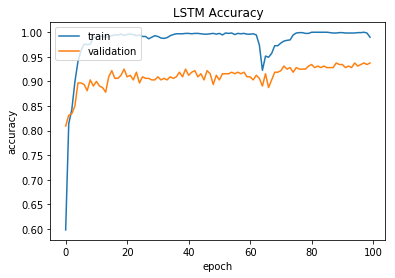

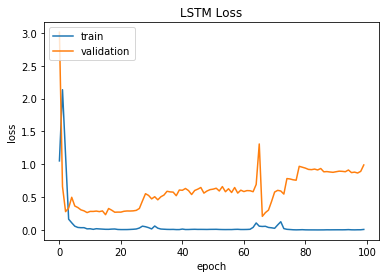

In [55]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('LSTM Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


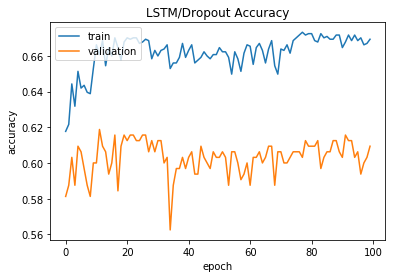

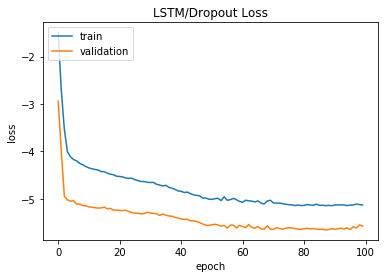

In [56]:
print(history_lstm.history.keys())
# summarize history for accuracy
plt.plot(history_lstm.history['acc'])
plt.plot(history_lstm.history['val_acc'])
plt.title('LSTM/Dropout Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('LSTM/Dropout Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


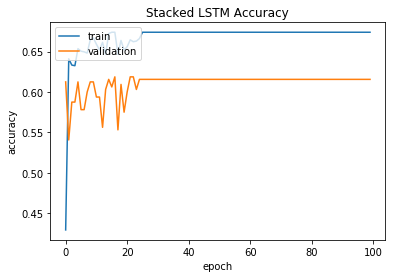

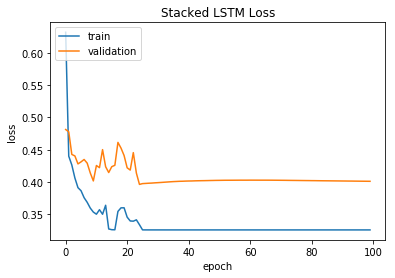

In [57]:
print(history_stacked.history.keys())
# summarize history for accuracy
plt.plot(history_stacked.history['acc'])
plt.plot(history_stacked.history['val_acc'])
plt.title('Stacked LSTM Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_stacked.history['loss'])
plt.plot(history_stacked.history['val_loss'])
plt.title('Stacked LSTM Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


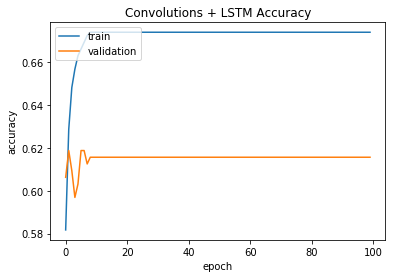

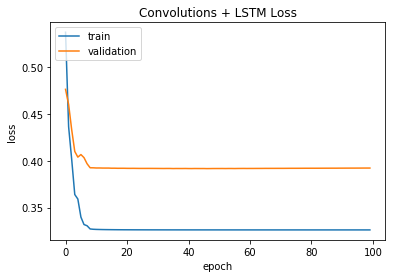

In [58]:
print(history_conv.history.keys())
# summarize history for accuracy
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('Convolutions + LSTM Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('Convolutions + LSTM Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


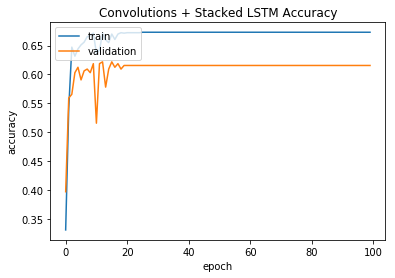

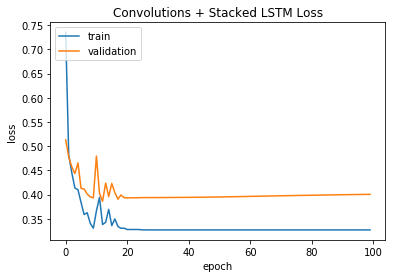

In [60]:
print(history_conv_stack.history.keys())
# summarize history for accuracy
plt.plot(history_conv_stack.history['acc'])
plt.plot(history_conv_stack.history['val_acc'])
plt.title('Convolutions + Stacked LSTM Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_conv_stack.history['loss'])
plt.plot(history_conv_stack.history['val_loss'])
plt.title('Convolutions + Stacked LSTM Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


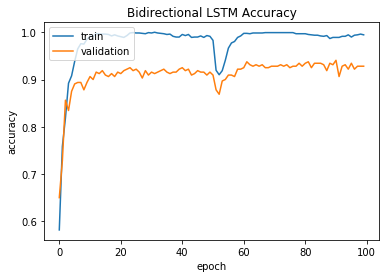

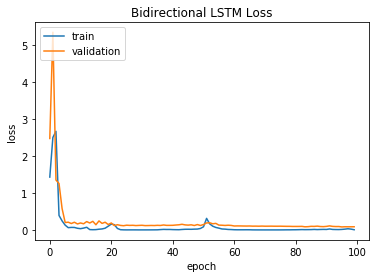

In [61]:
print(history_bi.history.keys())
# summarize history for accuracy
plt.plot(history_bi.history['acc'])
plt.plot(history_bi.history['val_acc'])
plt.title('Bidirectional LSTM Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_bi.history['loss'])
plt.plot(history_bi.history['val_loss'])
plt.title('Bidirectional LSTM Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()